In [1]:
import json
import pprint
import pickle
from math import log

# Get the RedditThread class from process.py
from process import RedditThread

# dataset source
# https://files.pushshift.io/reddit/comments/
pp = pprint.PrettyPrinter(indent=4)

In [2]:
politicsSubreddit = dict()
with open('lgbt.pkl', 'rb') as politics:
    politicsSubreddit = pickle.load(politics)

In [3]:
# builda dict of thread bodies by link_id

def build_thread_bodies(threads):
    thread_bodies = dict() # link_id: 'str w/ all comment text'
    to_delete = []
    for link_id in threads.keys():
        thread_bodies[link_id] = threads[link_id].body
            
        # PARSE RULES #
        thread_bodies[link_id] = thread_bodies[link_id].strip()
        thread_bodies[link_id] = thread_bodies[link_id].lower()
        thread_bodies[link_id] = thread_bodies[link_id].replace('\r\n\r\n', ' ')
        thread_bodies[link_id] = thread_bodies[link_id].replace('&gt;', '')
        thread_bodies[link_id] = thread_bodies[link_id].replace('\r', '')
        thread_bodies[link_id] = thread_bodies[link_id].replace('\n', '')
        
        if thread_bodies[link_id] == '[deleted]':
            to_delete.append(link_id)
    
    for link_id in to_delete:
        thread_bodies.pop(link_id, None)
        
    return thread_bodies

In [4]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models

import numpy as np
import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_distances
from scipy import spatial

In [5]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('Topic {}:'.format(topic_idx))
        print(' '.join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print('')

In [6]:
from sklearn.feature_extraction import text 

sw = text.ENGLISH_STOP_WORDS.union(['http', 'deleted', 'com', 'people', 'don', 'just', 'think', 'like'])

NUM_TOPICS = 5
NUM_WORDS = 5
PASSES = 20

thread_bodies = build_thread_bodies(politicsSubreddit)

# train LDA model

start = time.time()

train = list(thread_bodies.values())
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words=sw)
tf_train = tf_vectorizer.fit_transform(train)
tf_feature_names = tf_vectorizer.get_feature_names()

lda = LatentDirichletAllocation(
    n_topics=NUM_TOPICS, 
    max_iter=PASSES, 
    learning_method='online', 
    learning_offset=50., 
    random_state=0
)
lda.fit(tf_train)

display_topics(lda, tf_feature_names, NUM_WORDS)

end = time.time()

print('time elapsed: {} seconds'.format(end - start))

Topic 0:
gender woman male boyfriend really

Topic 1:
group sex men women know

Topic 2:
rick lot god real mean

Topic 3:
sex wouldn sexuality men simply

Topic 4:
gay did community coming things

time elapsed: 0.10350680351257324 seconds


/Users/Peterli/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [7]:
test_set = list(thread_bodies.values())
tf_test = tf_vectorizer.fit_transform(test_set)
predict = lda.transform(tf_test)

In [8]:
print('predictions available for {} elements\n'.format(len(predict)))
pp.pprint(predict)

predictions available for 16 elements

array([[1.08288707e-03, 9.95656994e-01, 1.08327076e-03, 1.08394398e-03,
        1.09290407e-03],
       [2.83089681e-04, 9.98864564e-01, 2.83203013e-04, 2.82645185e-04,
        2.86498212e-04],
       [9.59779741e-04, 9.74648530e-04, 9.60140469e-04, 9.58082674e-04,
        9.96147349e-01],
       [1.84980391e-03, 1.87615820e-03, 1.85161342e-03, 1.84788618e-03,
        9.92574538e-01],
       [2.42743450e-03, 9.90264516e-01, 2.42577533e-03, 2.42609712e-03,
        2.45617705e-03],
       [8.09492151e-03, 8.12765989e-03, 8.09044775e-03, 8.05595192e-03,
        9.67631019e-01],
       [4.26123053e-04, 9.98298072e-01, 4.24528027e-04, 4.24184261e-04,
        4.27092277e-04],
       [4.50047627e-03, 9.81927843e-01, 4.50186803e-03, 4.49613379e-03,
        4.57367917e-03],
       [7.80012869e-03, 9.68797277e-01, 7.78156709e-03, 7.76414664e-03,
        7.85688071e-03],
       [9.83194888e-01, 4.22712551e-03, 4.18694773e-03, 4.18347958e-03,
        4.207559

In [9]:
# Create matrix that stores cosine distances between predictions
# We use this because we don't care about the length of the vectors
start = time.time()

cos_dist_matrix = cosine_distances(predict, predict)

end = time.time()

print('time elapsed: {} seconds'.format(end - start))

time elapsed: 0.0008130073547363281 seconds


In [10]:
# Calculate the distance threshold we should use
# Currently std is really high and makes our graph very crowded
# What is a good way to do this
DIST_THRES = np.std(cos_dist_matrix) / 5
print(DIST_THRES)

0.09110877218488601


In [11]:
# ASSUMPTION: dict.keys() and dict.values() directly correspond if not modified
# rehydrate node_ids into dist_matrix -> distance lookup table

max_dist = float('-inf')
max_first, max_second = (None, None)

start = time.time()

dist_lookup = { node_id: {} for node_id in thread_bodies.keys() }
for idx1, first in enumerate(list(dist_lookup.keys())):
    for idx2, second in enumerate(list(dist_lookup.keys())):
        if cos_dist_matrix[idx1][idx2] > max_dist:
            max_dist = cos_dist_matrix[idx1][idx2]
            max_first, max_second = first, second
        dist_lookup[first][second] = cos_dist_matrix[idx1][idx2] # lazy eval

# check

mistakes = 0
for i in dist_lookup.keys():
    for j in dist_lookup.keys():
        if i==j and dist_lookup[i][j] != 0:
            print('something is off about dist_lookup[{}][{}] value {}'.format(i,j,dist_lookup[i][j]))
            mistakes += 1
        if dist_lookup[i][j] != dist_lookup[j][i]:
            mistakes += 1

end = time.time()

print('max distance seen: {} for {} and {}'.format(max_dist, max_first, max_second))
print('{} mistakes out of {} entries'.format(mistakes, len(dist_lookup) * len(dist_lookup)))
print('time elapsed: {} seconds'.format(end - start)) # 3mins to run on average

max distance seen: 0.998733942160446 for t3_akk2t and t3_ak9g8
0 mistakes out of 256 entries
time elapsed: 0.0007150173187255859 seconds


In [12]:
import networkx as nx
import matplotlib.pyplot as plt

k = 4

# construct network

start = time.time()

g = nx.Graph()
for thread_id in thread_bodies.keys():
    g.add_node(thread_id)

for first in thread_bodies.keys():
    dists_from_first = dist_lookup[first].items()
    sorted_dists_from_first = sorted([i for i in dists_from_first if i[1] > 0], key=lambda x: x[1])
    for (second, dist) in sorted_dists_from_first[:k]:
        if not g.has_edge(first, second):
            g.add_edge(first, second)

end = time.time()
print('time elapsed: {} seconds'.format(end - start))

time elapsed: 0.00041484832763671875 seconds


In [13]:
print(nx.is_connected(g))
degs = nx.degree_histogram(g)
# plt.hist(degs, normed=True, bins=len(degs))
# nx.density(g)
print(nx.info(g))

True
Name: 
Type: Graph
Number of nodes: 16
Number of edges: 44
Average degree:   5.5000


In [14]:
def save_and_show_visualization(g, file_name):
    plt.figure(figsize=(18,18))
    degrees = dict(nx.degree(g))
    
    spring_pos = nx.spectral_layout(g)
    
    # Draw networkx graph -- scale node size by log(degree+1)
    nx.draw_networkx(g,
                   pos=spring_pos,
                   with_labels=False, 
                   linewidths=2.0,
                   nodelist=degrees.keys(),
                   node_size=[log(degree_val+1) * 100 for degree_val in degrees.values()], \
                   node_color='r')
    
    # Create black border around node shapes
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#000000")

    # Save and show figure, then clear figure
    plt.savefig(file_name)
    plt.show()
    plt.clf()

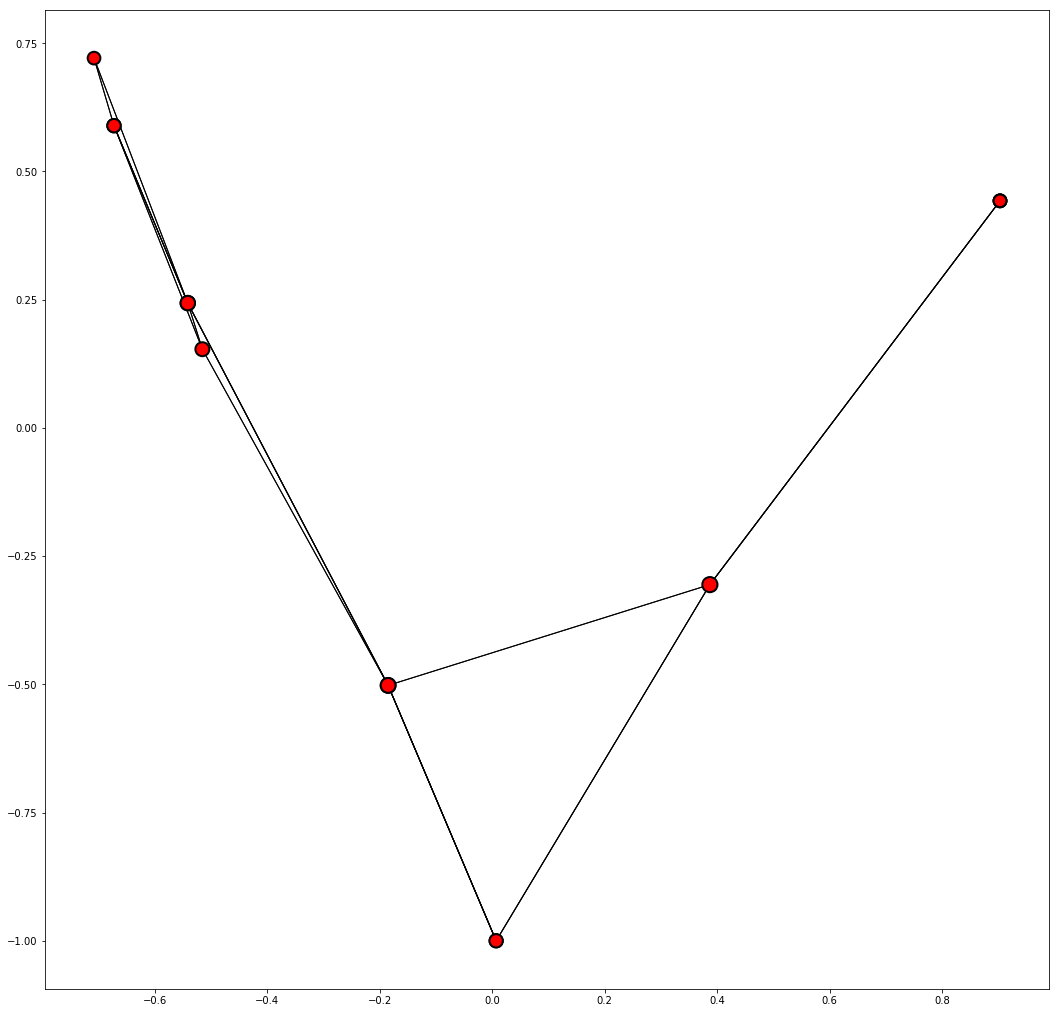

time elapsed: 0.34380102157592773 seconds


In [15]:
# visualize network
start = time.time()
save_and_show_visualization(g, "politics.pdf")
end = time.time()
print('time elapsed: {} seconds'.format(end - start))

In [16]:
from numpy.linalg import eigvals
egnvals = sorted(eigvals(nx.normalized_laplacian_matrix(g).A))
second_egnval = egnvals[1]

In [17]:
print(second_egnval/2)
print(second_egnval)
print(nx.shortest_path_length(g, max_first, max_second))
print(max_first, max_second)

0.060574327029102315
0.12114865405820463
4
t3_akk2t t3_ak9g8


In [18]:
# DONT RUN ME TOO MUCH, TAKES ~20MINS

complete_n = nx.complete_graph(len(set(g.nodes)))
egnvals_complete = sorted(eigvals(nx.normalized_laplacian_matrix(complete_n).A))
print(egnvals_complete[1])

1.0666666666666655


In [19]:
nx.diameter(g)

4

In [20]:
closeness = (1/nx.shortest_path_length(g, max_first, max_second)) * ((second_egnval*0.5) / (egnvals_complete[1]*0.5))
print(closeness)

0.02839421579489174
